In [1]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from models.inception_resnet_v1 import InceptionResnetV1
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, notebook
import csv
import glob
import dlib
import pandas as pd
import numpy as np
import dlib
from src.utils import renderFace
import matplotlib
%matplotlib inline

from src.imports import *

%config IPCompleter.greedy=True
%reload_ext autoreload

In [2]:
def printgpuinfo():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)
    
printgpuinfo()

Tue Aug 25 19:39:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    On   | 00000000:01:00.0  On |                  N/A |
| N/A   65C    P0    42W /  N/A |    407MiB /  8111MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:07:00.0 Off |                  N/A |
| 31%   52C    P5    37W / 250W |     12MiB /  7982MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
def showsysteminfo():
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    ram_gb_avail = virtual_memory().available / 1e9
    ram_gb_used = virtual_memory().active / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
    print('Your runtime has {:.1f} gigabytes of free RAM\n'.format(ram_gb_avail))
    print('Your runtime has {:.1f} gigabytes of used RAM\n'.format(ram_gb_used))    
showsysteminfo()

Your runtime has 33.6 gigabytes of available RAM

Your runtime has 29.8 gigabytes of free RAM

Your runtime has 4.3 gigabytes of used RAM



In [4]:
import torch
print(torch.__version__)

1.6.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

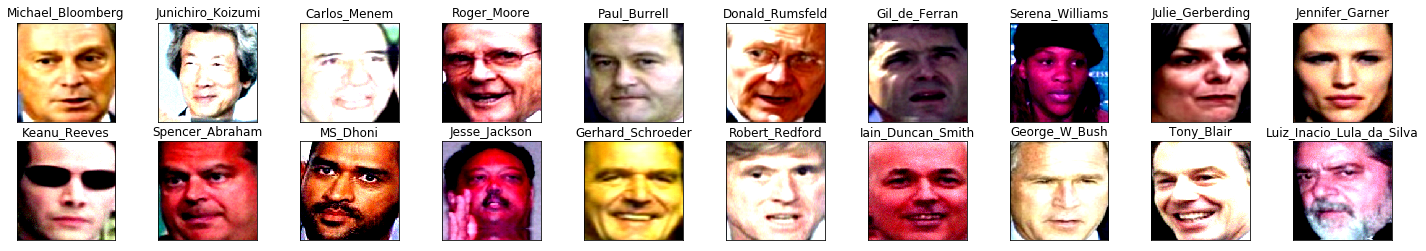

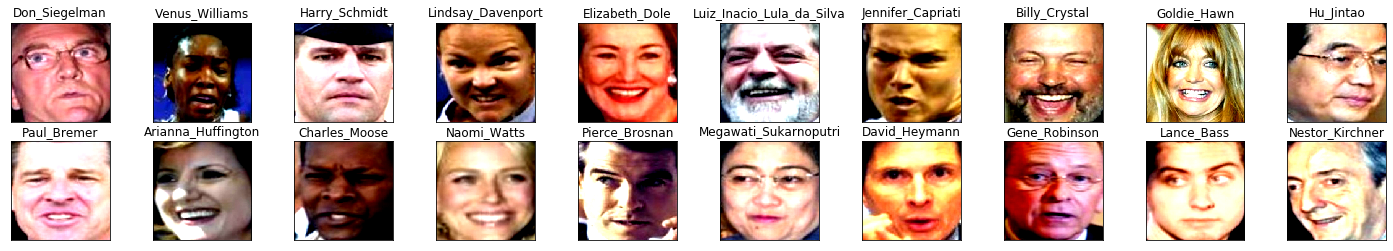

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms, test_transforms = preprochelper.PreprocHelper.getmnvetv2traintesttransforms(mean, std)


data_transforms = {
     'train': train_transforms,
     'val': test_transforms 
}

data_dir = '/media/abhijit/DATA/Development/MyRepos/lfw_funneled'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=512, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
# class_names

train_loader = dataloaders["train"]
test_loader = dataloaders["val"]

data_iterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(data_iterator, classes=class_names, image_count=20, col=5)

data_iterator = iter(test_loader)
plotdata.PlotData.showImagesfromdataset(data_iterator, classes=class_names, image_count=20, col=5)

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
from models.inception_resnet_v1 import InceptionResnetV1
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

Running on device: cuda


In [8]:
list(model_ft.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [9]:
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [10]:
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

In [11]:
for param in model_ft.parameters():
    param.requires_grad = False

In [12]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [13]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(layer_list[4].in_features, len(class_names))
# model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)

In [14]:
from src.train.train_model import TrainModel
train_model = TrainModel()
train_model.showmodelsummary(model_ft,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

In [15]:
lr_data = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

epochs = 500

#criterion = nn.NLLLoss() #nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.9, momentum=0.9)

# Decay LR by a factor of *gamma* every *step_size* epochs
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer_ft, base_lr=0.1, max_lr=2,
#                                                       mode='triangular2',
#                                                       cycle_momentum=True, step_size_up=5,
#                                                       step_size_down=20, )

In [16]:
train_model.start_training(epochs, model_ft, device, test_loader, train_loader, optimizer_ft, scheduler, lr_data,
                            class_correct, class_total, path="savedmodels/finalmodelwithdata.pt",use_mpt=False)

  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 0
Learning rate = 0.9  for epoch:  0
False


Loss=5.725511074066162 Batch_id=11 Accuracy=10.59: 100%|██████████| 12/12 [00:36<00:00,  3.01s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0110, Accuracy: 314/2506 (12.53%)

Validation accuracy increased (0.000000 --> 12.529928).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 1
Learning rate = 0.9  for epoch:  1
False


Loss=5.205297470092773 Batch_id=11 Accuracy=12.76: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0098, Accuracy: 509/2506 (20.31%)

Validation accuracy increased (12.529928 --> 20.311253).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 2
Learning rate = 0.9  for epoch:  2
False


Loss=5.050525188446045 Batch_id=11 Accuracy=19.46: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0091, Accuracy: 601/2506 (23.98%)

Validation accuracy increased (20.311253 --> 23.982442).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 3
Learning rate = 0.9  for epoch:  3
False


Loss=4.6448516845703125 Batch_id=11 Accuracy=24.41: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0086, Accuracy: 793/2506 (31.64%)

Validation accuracy increased (23.982442 --> 31.644054).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 4
Learning rate = 0.9  for epoch:  4
False


Loss=4.417465686798096 Batch_id=11 Accuracy=29.45: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0081, Accuracy: 876/2506 (34.96%)

Validation accuracy increased (31.644054 --> 34.956105).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 5
Learning rate = 0.9  for epoch:  5
False


Loss=4.140554428100586 Batch_id=11 Accuracy=32.02: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it]
100%|██████████| 5/5 [00:04<00:00,  1.20it/s]



Test set: Average loss: 0.0078, Accuracy: 943/2506 (37.63%)

Validation accuracy increased (34.956105 --> 37.629689).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 6
Learning rate = 0.9  for epoch:  6
False


Loss=4.136966705322266 Batch_id=11 Accuracy=34.48: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0075, Accuracy: 1019/2506 (40.66%)

Validation accuracy increased (37.629689 --> 40.662410).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 7
Learning rate = 0.9  for epoch:  7
False


Loss=3.875361919403076 Batch_id=11 Accuracy=37.42: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0072, Accuracy: 1106/2506 (44.13%)

Validation accuracy increased (40.662410 --> 44.134078).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 8
Learning rate = 0.9  for epoch:  8
False


Loss=3.8869972229003906 Batch_id=11 Accuracy=39.65: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0069, Accuracy: 1167/2506 (46.57%)

Validation accuracy increased (44.134078 --> 46.568236).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 9
Learning rate = 0.9  for epoch:  9
False


Loss=3.7184858322143555 Batch_id=11 Accuracy=41.74: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0067, Accuracy: 1223/2506 (48.80%)

Validation accuracy increased (46.568236 --> 48.802873).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 10
Learning rate = 0.9  for epoch:  10
False


Loss=3.7438600063323975 Batch_id=11 Accuracy=43.56: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0064, Accuracy: 1270/2506 (50.68%)

Validation accuracy increased (48.802873 --> 50.678372).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 11
Learning rate = 0.9  for epoch:  11
False


Loss=3.5697247982025146 Batch_id=11 Accuracy=45.12: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.20it/s]



Test set: Average loss: 0.0062, Accuracy: 1326/2506 (52.91%)

Validation accuracy increased (50.678372 --> 52.913009).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 12
Learning rate = 0.9  for epoch:  12
False


Loss=3.3193747997283936 Batch_id=11 Accuracy=46.74: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0060, Accuracy: 1370/2506 (54.67%)

Validation accuracy increased (52.913009 --> 54.668795).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 13
Learning rate = 0.9  for epoch:  13
False


Loss=3.5277938842773438 Batch_id=11 Accuracy=48.22: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0058, Accuracy: 1384/2506 (55.23%)

Validation accuracy increased (54.668795 --> 55.227454).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 14
Learning rate = 0.9  for epoch:  14
False


Loss=3.0463602542877197 Batch_id=11 Accuracy=49.07: 100%|██████████| 12/12 [00:31<00:00,  2.60s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0057, Accuracy: 1430/2506 (57.06%)

Validation accuracy increased (55.227454 --> 57.063049).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 15
Learning rate = 0.9  for epoch:  15
False


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0055, Accuracy: 1465/2506 (58.46%)

Validation accuracy increased (57.063049 --> 58.459697).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 16
Learning rate = 0.9  for epoch:  16
False


Loss=3.261077642440796 Batch_id=11 Accuracy=51.69: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0053, Accuracy: 1498/2506 (59.78%)

Validation accuracy increased (58.459697 --> 59.776536).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 17
Learning rate = 0.9  for epoch:  17
False


Loss=3.224457263946533 Batch_id=11 Accuracy=53.18: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.20it/s]



Test set: Average loss: 0.0052, Accuracy: 1539/2506 (61.41%)

Validation accuracy increased (59.776536 --> 61.412610).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 18
Learning rate = 0.9  for epoch:  18
False


Loss=2.904029607772827 Batch_id=11 Accuracy=54.36: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.14it/s]



Test set: Average loss: 0.0051, Accuracy: 1563/2506 (62.37%)

Validation accuracy increased (61.412610 --> 62.370311).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 19
Learning rate = 0.9  for epoch:  19
False


Loss=2.9841973781585693 Batch_id=11 Accuracy=55.56: 100%|██████████| 12/12 [00:31<00:00,  2.58s/it]
100%|██████████| 5/5 [00:04<00:00,  1.20it/s]



Test set: Average loss: 0.0049, Accuracy: 1609/2506 (64.21%)

Validation accuracy increased (62.370311 --> 64.205906).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 20
Learning rate = 0.9  for epoch:  20
False


Loss=2.863102674484253 Batch_id=11 Accuracy=56.59: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0048, Accuracy: 1642/2506 (65.52%)

Validation accuracy increased (64.205906 --> 65.522745).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 21
Learning rate = 0.9  for epoch:  21
False


Loss=2.588210105895996 Batch_id=11 Accuracy=57.21: 100%|██████████| 12/12 [00:31<00:00,  2.59s/it]
100%|██████████| 5/5 [00:04<00:00,  1.20it/s]



Test set: Average loss: 0.0047, Accuracy: 1672/2506 (66.72%)

Validation accuracy increased (65.522745 --> 66.719872).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 22
Learning rate = 0.9  for epoch:  22
False


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0046, Accuracy: 1685/2506 (67.24%)

Validation accuracy increased (66.719872 --> 67.238627).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 23
Learning rate = 0.9  for epoch:  23
False


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0045, Accuracy: 1717/2506 (68.52%)

Validation accuracy increased (67.238627 --> 68.515563).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 24
Learning rate = 0.9  for epoch:  24
False


Loss=2.5385513305664062 Batch_id=11 Accuracy=60.01: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]
100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



Test set: Average loss: 0.0044, Accuracy: 1730/2506 (69.03%)

Validation accuracy increased (68.515563 --> 69.034318).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 25
Learning rate = 0.9  for epoch:  25
False


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0043, Accuracy: 1763/2506 (70.35%)

Validation accuracy increased (69.034318 --> 70.351157).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 26
Learning rate = 0.9  for epoch:  26
False


Loss=2.424868106842041 Batch_id=11 Accuracy=61.31: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0042, Accuracy: 1776/2506 (70.87%)

Validation accuracy increased (70.351157 --> 70.869912).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 27
Learning rate = 0.9  for epoch:  27
False


Loss=2.6994423866271973 Batch_id=11 Accuracy=62.38: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.20it/s]



Test set: Average loss: 0.0041, Accuracy: 1781/2506 (71.07%)

Validation accuracy increased (70.869912 --> 71.069433).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 28
Learning rate = 0.9  for epoch:  28
False


Loss=2.490481376647949 Batch_id=11 Accuracy=62.78: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.15it/s]



Test set: Average loss: 0.0040, Accuracy: 1804/2506 (71.99%)

Validation accuracy increased (71.069433 --> 71.987231).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 29
Learning rate = 0.9  for epoch:  29
False


Loss=2.4369022846221924 Batch_id=11 Accuracy=63.23: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0039, Accuracy: 1827/2506 (72.91%)

Validation accuracy increased (71.987231 --> 72.905028).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 30
Learning rate = 0.9  for epoch:  30
False


Loss=2.3805792331695557 Batch_id=11 Accuracy=64.30: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0038, Accuracy: 1837/2506 (73.30%)

Validation accuracy increased (72.905028 --> 73.304070).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 31
Learning rate = 0.9  for epoch:  31
False


Loss=2.343637704849243 Batch_id=11 Accuracy=64.67: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0038, Accuracy: 1848/2506 (73.74%)

Validation accuracy increased (73.304070 --> 73.743017).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 32
Learning rate = 0.9  for epoch:  32
False


Loss=2.292701482772827 Batch_id=11 Accuracy=65.03: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0037, Accuracy: 1851/2506 (73.86%)

Validation accuracy increased (73.743017 --> 73.862729).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 33
Learning rate = 0.9  for epoch:  33
False


Loss=2.199312448501587 Batch_id=11 Accuracy=65.62: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0036, Accuracy: 1861/2506 (74.26%)

Validation accuracy increased (73.862729 --> 74.261772).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 34
Learning rate = 0.9  for epoch:  34
False


Loss=2.109433889389038 Batch_id=11 Accuracy=65.90: 100%|██████████| 12/12 [00:31<00:00,  2.60s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0035, Accuracy: 1870/2506 (74.62%)

Validation accuracy increased (74.261772 --> 74.620910).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 35
Learning rate = 0.9  for epoch:  35
False


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]



Test set: Average loss: 0.0035, Accuracy: 1885/2506 (75.22%)

Validation accuracy increased (74.620910 --> 75.219473).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 36
Learning rate = 0.9  for epoch:  36
False


Loss=2.057464361190796 Batch_id=11 Accuracy=66.60: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0034, Accuracy: 1885/2506 (75.22%)

Validation accuracy increased (75.219473 --> 75.219473).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 37
Learning rate = 0.9  for epoch:  37
False


Loss=2.246609926223755 Batch_id=11 Accuracy=66.93: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0034, Accuracy: 1888/2506 (75.34%)

Validation accuracy increased (75.219473 --> 75.339186).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 38
Learning rate = 0.9  for epoch:  38
False


Loss=2.147258996963501 Batch_id=11 Accuracy=67.33: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0033, Accuracy: 1900/2506 (75.82%)

Validation accuracy increased (75.339186 --> 75.818037).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 39
Learning rate = 0.9  for epoch:  39
False


Loss=1.9931033849716187 Batch_id=11 Accuracy=67.82: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0032, Accuracy: 1902/2506 (75.90%)

Validation accuracy increased (75.818037 --> 75.897845).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 40
Learning rate = 0.9  for epoch:  40
False


Loss=1.8139960765838623 Batch_id=11 Accuracy=68.17: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0032, Accuracy: 1911/2506 (76.26%)

Validation accuracy increased (75.897845 --> 76.256983).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 41
Learning rate = 0.9  for epoch:  41
False


Loss=2.0477707386016846 Batch_id=11 Accuracy=68.25: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0031, Accuracy: 1911/2506 (76.26%)

Validation accuracy increased (76.256983 --> 76.256983).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 42
Learning rate = 0.9  for epoch:  42
False


Loss=1.9752260446548462 Batch_id=11 Accuracy=69.00: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0031, Accuracy: 1925/2506 (76.82%)

Validation accuracy increased (76.256983 --> 76.815642).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 43
Learning rate = 0.9  for epoch:  43
False


Loss=1.8063199520111084 Batch_id=11 Accuracy=69.18: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0030, Accuracy: 1932/2506 (77.09%)

Validation accuracy increased (76.815642 --> 77.094972).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 44
Learning rate = 0.9  for epoch:  44
False


Loss=1.873097538948059 Batch_id=11 Accuracy=69.40: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0030, Accuracy: 1935/2506 (77.21%)

Validation accuracy increased (77.094972 --> 77.214685).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 45
Learning rate = 0.9  for epoch:  45
False


Loss=1.8538388013839722 Batch_id=11 Accuracy=69.57: 100%|██████████| 12/12 [00:31<00:00,  2.64s/it]
100%|██████████| 5/5 [00:04<00:00,  1.21it/s]



Test set: Average loss: 0.0029, Accuracy: 1944/2506 (77.57%)

Validation accuracy increased (77.214685 --> 77.573823).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 46
Learning rate = 0.9  for epoch:  46
False


Loss=1.7131659984588623 Batch_id=11 Accuracy=70.27: 100%|██████████| 12/12 [00:31<00:00,  2.60s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0029, Accuracy: 1947/2506 (77.69%)

Validation accuracy increased (77.573823 --> 77.693536).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 47
Learning rate = 0.9  for epoch:  47
False


Loss=1.7619707584381104 Batch_id=11 Accuracy=70.77: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0029, Accuracy: 1960/2506 (78.21%)

Validation accuracy increased (77.693536 --> 78.212291).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 48
Learning rate = 0.9  for epoch:  48
False


Loss=1.558597445487976 Batch_id=11 Accuracy=70.77: 100%|██████████| 12/12 [00:31<00:00,  2.64s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0028, Accuracy: 1961/2506 (78.25%)

Validation accuracy increased (78.212291 --> 78.252195).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 49
Learning rate = 0.9  for epoch:  49
False


Loss=1.7073302268981934 Batch_id=11 Accuracy=71.32: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.20it/s]



Test set: Average loss: 0.0028, Accuracy: 1974/2506 (78.77%)

Validation accuracy increased (78.252195 --> 78.770950).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 50
Learning rate = 0.9  for epoch:  50
False


Loss=1.6604005098342896 Batch_id=11 Accuracy=71.95: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0027, Accuracy: 1977/2506 (78.89%)

Validation accuracy increased (78.770950 --> 78.890662).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 51
Learning rate = 0.9  for epoch:  51
False


Loss=1.4860836267471313 Batch_id=11 Accuracy=72.44: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0027, Accuracy: 1984/2506 (79.17%)

Validation accuracy increased (78.890662 --> 79.169992).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 52
Learning rate = 0.9  for epoch:  52
False


Loss=1.6563674211502075 Batch_id=11 Accuracy=72.54: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0026, Accuracy: 1992/2506 (79.49%)

Validation accuracy increased (79.169992 --> 79.489226).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 53
Learning rate = 0.9  for epoch:  53
False


Loss=1.5445220470428467 Batch_id=11 Accuracy=73.09: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0026, Accuracy: 1994/2506 (79.57%)

Validation accuracy increased (79.489226 --> 79.569034).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 54
Learning rate = 0.9  for epoch:  54
False


Loss=1.4761360883712769 Batch_id=11 Accuracy=73.40: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0026, Accuracy: 1997/2506 (79.69%)

Validation accuracy increased (79.569034 --> 79.688747).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 55
Learning rate = 0.9  for epoch:  55
False


Loss=1.5810273885726929 Batch_id=11 Accuracy=73.89: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0025, Accuracy: 2009/2506 (80.17%)

Validation accuracy increased (79.688747 --> 80.167598).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 56
Learning rate = 0.9  for epoch:  56
False


Loss=1.6292219161987305 Batch_id=11 Accuracy=74.47: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 2008/2506 (80.13%)

EPOCH: 57
Learning rate = 0.9  for epoch:  57
False


Loss=1.5940485000610352 Batch_id=11 Accuracy=74.89: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0025, Accuracy: 2029/2506 (80.97%)

Validation accuracy increased (80.167598 --> 80.965682).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 58
Learning rate = 0.9  for epoch:  58
False


Loss=1.468580722808838 Batch_id=11 Accuracy=75.34: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 2025/2506 (80.81%)

EPOCH: 59
Learning rate = 0.9  for epoch:  59
False


Loss=1.504977822303772 Batch_id=11 Accuracy=75.67: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0024, Accuracy: 2031/2506 (81.05%)

Validation accuracy increased (80.965682 --> 81.045491).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 60
Learning rate = 0.9  for epoch:  60
False


Loss=1.5778330564498901 Batch_id=11 Accuracy=76.62: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0024, Accuracy: 2039/2506 (81.36%)

Validation accuracy increased (81.045491 --> 81.364725).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 61
Learning rate = 0.9  for epoch:  61
False


Loss=1.4328504800796509 Batch_id=11 Accuracy=76.55: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0023, Accuracy: 2043/2506 (81.52%)

Validation accuracy increased (81.364725 --> 81.524342).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 62
Learning rate = 0.9  for epoch:  62
False


Loss=1.3594263792037964 Batch_id=11 Accuracy=77.02: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0023, Accuracy: 2052/2506 (81.88%)

Validation accuracy increased (81.524342 --> 81.883480).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 63
Learning rate = 0.9  for epoch:  63
False


Loss=1.4289288520812988 Batch_id=11 Accuracy=77.69: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.20it/s]



Test set: Average loss: 0.0023, Accuracy: 2055/2506 (82.00%)

Validation accuracy increased (81.883480 --> 82.003192).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 64
Learning rate = 0.9  for epoch:  64
False


Loss=1.4740912914276123 Batch_id=11 Accuracy=77.99: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0023, Accuracy: 2061/2506 (82.24%)

Validation accuracy increased (82.003192 --> 82.242618).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 65
Learning rate = 0.9  for epoch:  65
False


Loss=1.4166429042816162 Batch_id=11 Accuracy=78.17: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0022, Accuracy: 2071/2506 (82.64%)

Validation accuracy increased (82.242618 --> 82.641660).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 66
Learning rate = 0.9  for epoch:  66
False


Loss=1.4393401145935059 Batch_id=11 Accuracy=78.79: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0022, Accuracy: 2072/2506 (82.68%)

Validation accuracy increased (82.641660 --> 82.681564).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 67
Learning rate = 0.9  for epoch:  67
False


Loss=1.4220472574234009 Batch_id=11 Accuracy=79.69: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0022, Accuracy: 2076/2506 (82.84%)

Validation accuracy increased (82.681564 --> 82.841181).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 68
Learning rate = 0.9  for epoch:  68
False


Loss=1.329016923904419 Batch_id=11 Accuracy=79.49: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0021, Accuracy: 2086/2506 (83.24%)

Validation accuracy increased (82.841181 --> 83.240223).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 69
Learning rate = 0.9  for epoch:  69
False


Loss=1.3029431104660034 Batch_id=11 Accuracy=80.26: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 2084/2506 (83.16%)

EPOCH: 70
Learning rate = 0.9  for epoch:  70
False


Loss=1.2549906969070435 Batch_id=11 Accuracy=80.72: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0021, Accuracy: 2089/2506 (83.36%)

Validation accuracy increased (83.240223 --> 83.359936).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 71
Learning rate = 0.9  for epoch:  71
False


Loss=1.2617183923721313 Batch_id=11 Accuracy=80.69: 100%|██████████| 12/12 [00:35<00:00,  2.98s/it]
100%|██████████| 5/5 [00:04<00:00,  1.14it/s]



Test set: Average loss: 0.0021, Accuracy: 2113/2506 (84.32%)

Validation accuracy increased (83.359936 --> 84.317638).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 72
Learning rate = 0.9  for epoch:  72
False


Loss=1.4881364107131958 Batch_id=11 Accuracy=81.34: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 2110/2506 (84.20%)

EPOCH: 73
Learning rate = 0.9  for epoch:  73
False


Loss=1.375663161277771 Batch_id=11 Accuracy=82.07: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 2112/2506 (84.28%)

EPOCH: 74
Learning rate = 0.9  for epoch:  74
False


Loss=1.0524991750717163 Batch_id=11 Accuracy=82.27: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0020, Accuracy: 2122/2506 (84.68%)

Validation accuracy increased (84.317638 --> 84.676776).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 75
Learning rate = 0.9  for epoch:  75
False


Loss=1.187533974647522 Batch_id=11 Accuracy=82.46: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0020, Accuracy: 2130/2506 (85.00%)

Validation accuracy increased (84.676776 --> 84.996010).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 76
Learning rate = 0.9  for epoch:  76
False


Loss=1.2417616844177246 Batch_id=11 Accuracy=82.79: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 2125/2506 (84.80%)

EPOCH: 77
Learning rate = 0.9  for epoch:  77
False


Loss=1.0933722257614136 Batch_id=11 Accuracy=83.36: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0019, Accuracy: 2138/2506 (85.32%)

Validation accuracy increased (84.996010 --> 85.315243).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 78
Learning rate = 0.9  for epoch:  78
False


Loss=1.097832441329956 Batch_id=11 Accuracy=83.69: 100%|██████████| 12/12 [00:32<00:00,  2.75s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0019, Accuracy: 2149/2506 (85.75%)

Validation accuracy increased (85.315243 --> 85.754190).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 79
Learning rate = 0.9  for epoch:  79
False


Loss=1.173183798789978 Batch_id=11 Accuracy=84.13: 100%|██████████| 12/12 [00:31<00:00,  2.64s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 2143/2506 (85.51%)

EPOCH: 80
Learning rate = 0.9  for epoch:  80
False


Loss=1.0377601385116577 Batch_id=11 Accuracy=84.34: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0019, Accuracy: 2151/2506 (85.83%)

Validation accuracy increased (85.754190 --> 85.833998).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 81
Learning rate = 0.9  for epoch:  81
False


Loss=1.168601632118225 Batch_id=11 Accuracy=84.78: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
100%|██████████| 5/5 [00:04<00:00,  1.07it/s]



Test set: Average loss: 0.0018, Accuracy: 2155/2506 (85.99%)

Validation accuracy increased (85.833998 --> 85.993615).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 82
Learning rate = 0.9  for epoch:  82
False


Loss=1.0098321437835693 Batch_id=11 Accuracy=85.36: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0018, Accuracy: 2165/2506 (86.39%)

Validation accuracy increased (85.993615 --> 86.392658).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 83
Learning rate = 0.9  for epoch:  83
False


Loss=1.0888041257858276 Batch_id=11 Accuracy=85.03: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0018, Accuracy: 2171/2506 (86.63%)

Validation accuracy increased (86.392658 --> 86.632083).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 84
Learning rate = 0.9  for epoch:  84
False


Loss=1.042564034461975 Batch_id=11 Accuracy=85.39: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.13it/s]



Test set: Average loss: 0.0018, Accuracy: 2180/2506 (86.99%)

Validation accuracy increased (86.632083 --> 86.991221).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 85
Learning rate = 0.9  for epoch:  85
False


Loss=0.9612928628921509 Batch_id=11 Accuracy=86.09: 100%|██████████| 12/12 [00:34<00:00,  2.91s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 2179/2506 (86.95%)

EPOCH: 86
Learning rate = 0.9  for epoch:  86
False


Loss=1.0553340911865234 Batch_id=11 Accuracy=86.48: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 2171/2506 (86.63%)

EPOCH: 87
Learning rate = 0.9  for epoch:  87
False


Loss=1.0931260585784912 Batch_id=11 Accuracy=86.49: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0017, Accuracy: 2189/2506 (87.35%)

Validation accuracy increased (86.991221 --> 87.350359).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 88
Learning rate = 0.9  for epoch:  88
False


Loss=1.028032660484314 Batch_id=11 Accuracy=86.89: 100%|██████████| 12/12 [00:35<00:00,  2.95s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.11it/s]



Test set: Average loss: 0.0017, Accuracy: 2195/2506 (87.59%)

Validation accuracy increased (87.350359 --> 87.589785).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 89
Learning rate = 0.9  for epoch:  89
False


Loss=1.0326721668243408 Batch_id=11 Accuracy=87.34: 100%|██████████| 12/12 [00:35<00:00,  2.95s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0017, Accuracy: 2198/2506 (87.71%)

Validation accuracy increased (87.589785 --> 87.709497).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 90
Learning rate = 0.9  for epoch:  90
False


Loss=0.9307156205177307 Batch_id=11 Accuracy=88.16: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0017, Accuracy: 2202/2506 (87.87%)

Validation accuracy increased (87.709497 --> 87.869114).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 91
Learning rate = 0.9  for epoch:  91
False


Loss=0.9865535497665405 Batch_id=11 Accuracy=87.93: 100%|██████████| 12/12 [00:34<00:00,  2.87s/it]
100%|██████████| 5/5 [00:04<00:00,  1.14it/s]



Test set: Average loss: 0.0017, Accuracy: 2212/2506 (88.27%)

Validation accuracy increased (87.869114 --> 88.268156).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 92
Learning rate = 0.9  for epoch:  92
False


Loss=1.1014631986618042 Batch_id=11 Accuracy=88.64: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0016, Accuracy: 2214/2506 (88.35%)

Validation accuracy increased (88.268156 --> 88.347965).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 93
Learning rate = 0.9  for epoch:  93
False


Loss=0.944769024848938 Batch_id=11 Accuracy=88.89: 100%|██████████| 12/12 [00:33<00:00,  2.80s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.15it/s]



Test set: Average loss: 0.0016, Accuracy: 2215/2506 (88.39%)

Validation accuracy increased (88.347965 --> 88.387869).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 94
Learning rate = 0.9  for epoch:  94
False


Loss=0.8811364769935608 Batch_id=11 Accuracy=88.98: 100%|██████████| 12/12 [00:34<00:00,  2.88s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0016, Accuracy: 2219/2506 (88.55%)

Validation accuracy increased (88.387869 --> 88.547486).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 95
Learning rate = 0.9  for epoch:  95
False


Loss=1.0025482177734375 Batch_id=11 Accuracy=89.59: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it]
100%|██████████| 5/5 [00:04<00:00,  1.10it/s]



Test set: Average loss: 0.0016, Accuracy: 2224/2506 (88.75%)

Validation accuracy increased (88.547486 --> 88.747007).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 96
Learning rate = 0.9  for epoch:  96
False


Loss=0.8971584439277649 Batch_id=11 Accuracy=89.64: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0016, Accuracy: 2231/2506 (89.03%)

Validation accuracy increased (88.747007 --> 89.026337).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 97
Learning rate = 0.9  for epoch:  97
False


Loss=0.9052125811576843 Batch_id=11 Accuracy=90.01: 100%|██████████| 12/12 [00:35<00:00,  2.97s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0016, Accuracy: 2237/2506 (89.27%)

Validation accuracy increased (89.026337 --> 89.265762).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 98
Learning rate = 0.9  for epoch:  98
False


Loss=0.9178423881530762 Batch_id=11 Accuracy=90.53: 100%|██████████| 12/12 [00:35<00:00,  2.93s/it]
100%|██████████| 5/5 [00:04<00:00,  1.10it/s]



Test set: Average loss: 0.0015, Accuracy: 2244/2506 (89.55%)

Validation accuracy increased (89.265762 --> 89.545092).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 99
Learning rate = 0.9  for epoch:  99
False


Loss=0.903838038444519 Batch_id=11 Accuracy=91.00: 100%|██████████| 12/12 [00:35<00:00,  2.95s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2241/2506 (89.43%)

EPOCH: 100
Learning rate = 0.09000000000000001  for epoch:  100
False


Loss=0.8909057378768921 Batch_id=11 Accuracy=90.98: 100%|██████████| 12/12 [00:33<00:00,  2.80s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0015, Accuracy: 2244/2506 (89.55%)

Validation accuracy increased (89.545092 --> 89.545092).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 101
Learning rate = 0.09000000000000001  for epoch:  101
False


Loss=0.784191906452179 Batch_id=11 Accuracy=91.65: 100%|██████████| 12/12 [00:33<00:00,  2.75s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.14it/s]



Test set: Average loss: 0.0015, Accuracy: 2247/2506 (89.66%)

Validation accuracy increased (89.545092 --> 89.664804).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 102
Learning rate = 0.09000000000000001  for epoch:  102
False


Loss=0.7192860245704651 Batch_id=11 Accuracy=91.78: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0015, Accuracy: 2251/2506 (89.82%)

Validation accuracy increased (89.664804 --> 89.824421).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 103
Learning rate = 0.09000000000000001  for epoch:  103
False


Loss=0.7840877175331116 Batch_id=11 Accuracy=91.88: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2250/2506 (89.78%)

EPOCH: 104
Learning rate = 0.09000000000000001  for epoch:  104
False


Loss=0.8999915719032288 Batch_id=11 Accuracy=91.76: 100%|██████████| 12/12 [00:32<00:00,  2.75s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2246/2506 (89.62%)

EPOCH: 105
Learning rate = 0.09000000000000001  for epoch:  105
False


Loss=0.8030017018318176 Batch_id=11 Accuracy=91.85: 100%|██████████| 12/12 [00:33<00:00,  2.77s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2245/2506 (89.58%)

EPOCH: 106
Learning rate = 0.09000000000000001  for epoch:  106
False


Loss=0.8538641333580017 Batch_id=11 Accuracy=92.05: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0015, Accuracy: 2253/2506 (89.90%)

Validation accuracy increased (89.824421 --> 89.904230).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 107
Learning rate = 0.09000000000000001  for epoch:  107
False


Loss=0.8554092049598694 Batch_id=11 Accuracy=91.93: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2249/2506 (89.74%)

EPOCH: 108
Learning rate = 0.09000000000000001  for epoch:  108
False


Loss=0.7402726411819458 Batch_id=11 Accuracy=92.05: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2250/2506 (89.78%)

EPOCH: 109
Learning rate = 0.09000000000000001  for epoch:  109
False


Loss=0.8321403861045837 Batch_id=11 Accuracy=92.16: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0015, Accuracy: 2253/2506 (89.90%)

Validation accuracy increased (89.904230 --> 89.904230).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 110
Learning rate = 0.09000000000000001  for epoch:  110
False


Loss=0.8695619106292725 Batch_id=11 Accuracy=91.98: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0015, Accuracy: 2256/2506 (90.02%)

Validation accuracy increased (89.904230 --> 90.023943).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 111
Learning rate = 0.09000000000000001  for epoch:  111
False


Loss=0.7878105044364929 Batch_id=11 Accuracy=92.03: 100%|██████████| 12/12 [00:33<00:00,  2.75s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2252/2506 (89.86%)

EPOCH: 112
Learning rate = 0.09000000000000001  for epoch:  112
False


Loss=0.7566514015197754 Batch_id=11 Accuracy=92.01: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2251/2506 (89.82%)

EPOCH: 113
Learning rate = 0.09000000000000001  for epoch:  113
False


Loss=0.8171452879905701 Batch_id=11 Accuracy=92.10: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2252/2506 (89.86%)

EPOCH: 114
Learning rate = 0.09000000000000001  for epoch:  114
False


Loss=0.8446558117866516 Batch_id=11 Accuracy=92.20: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2254/2506 (89.94%)

EPOCH: 115
Learning rate = 0.09000000000000001  for epoch:  115
False


Loss=0.8268260359764099 Batch_id=11 Accuracy=92.46: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2251/2506 (89.82%)

EPOCH: 116
Learning rate = 0.09000000000000001  for epoch:  116
False


Loss=0.7475868463516235 Batch_id=11 Accuracy=92.31: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2254/2506 (89.94%)

EPOCH: 117
Learning rate = 0.09000000000000001  for epoch:  117
False


Loss=0.8376514911651611 Batch_id=11 Accuracy=92.50: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0015, Accuracy: 2258/2506 (90.10%)

Validation accuracy increased (90.023943 --> 90.103751).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 118
Learning rate = 0.09000000000000001  for epoch:  118
False


Loss=0.8427460193634033 Batch_id=11 Accuracy=92.26: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2255/2506 (89.98%)

EPOCH: 119
Learning rate = 0.09000000000000001  for epoch:  119
False


Loss=0.8654112219810486 Batch_id=11 Accuracy=92.58: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2253/2506 (89.90%)

EPOCH: 120
Learning rate = 0.09000000000000001  for epoch:  120
False


  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2257/2506 (90.06%)

EPOCH: 121
Learning rate = 0.09000000000000001  for epoch:  121
False


Loss=0.7410367727279663 Batch_id=11 Accuracy=92.93: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]
100%|██████████| 5/5 [00:04<00:00,  1.21it/s]



Test set: Average loss: 0.0015, Accuracy: 2259/2506 (90.14%)

Validation accuracy increased (90.103751 --> 90.143655).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 122
Learning rate = 0.09000000000000001  for epoch:  122
False


Loss=0.7335209846496582 Batch_id=11 Accuracy=92.78: 100%|██████████| 12/12 [00:31<00:00,  2.64s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2256/2506 (90.02%)

EPOCH: 123
Learning rate = 0.09000000000000001  for epoch:  123
False


Loss=0.8600700497627258 Batch_id=11 Accuracy=92.93: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0015, Accuracy: 2262/2506 (90.26%)

Validation accuracy increased (90.143655 --> 90.263368).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 124
Learning rate = 0.09000000000000001  for epoch:  124
False


Loss=0.7538539171218872 Batch_id=11 Accuracy=92.38: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2256/2506 (90.02%)

EPOCH: 125
Learning rate = 0.09000000000000001  for epoch:  125
False


Loss=0.7894465327262878 Batch_id=11 Accuracy=92.43: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2258/2506 (90.10%)

EPOCH: 126
Learning rate = 0.09000000000000001  for epoch:  126
False


Loss=0.7978193163871765 Batch_id=11 Accuracy=92.45: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2260/2506 (90.18%)

EPOCH: 127
Learning rate = 0.09000000000000001  for epoch:  127
False


Loss=0.7666193842887878 Batch_id=11 Accuracy=92.55: 100%|██████████| 12/12 [00:34<00:00,  2.86s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2259/2506 (90.14%)

EPOCH: 128
Learning rate = 0.09000000000000001  for epoch:  128
False


Loss=0.8716074228286743 Batch_id=11 Accuracy=93.08: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2259/2506 (90.14%)

EPOCH: 129
Learning rate = 0.09000000000000001  for epoch:  129
False


Loss=0.8844925761222839 Batch_id=11 Accuracy=92.36: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
100%|██████████| 5/5 [00:04<00:00,  1.15it/s]



Test set: Average loss: 0.0015, Accuracy: 2263/2506 (90.30%)

Validation accuracy increased (90.263368 --> 90.303272).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 130
Learning rate = 0.09000000000000001  for epoch:  130
False


Loss=0.7635291814804077 Batch_id=11 Accuracy=92.81: 100%|██████████| 12/12 [00:32<00:00,  2.75s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2262/2506 (90.26%)

EPOCH: 131
Learning rate = 0.09000000000000001  for epoch:  131
False


Loss=0.8777544498443604 Batch_id=11 Accuracy=93.25: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0015, Accuracy: 2263/2506 (90.30%)

Validation accuracy increased (90.303272 --> 90.303272).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 132
Learning rate = 0.09000000000000001  for epoch:  132
False


Loss=0.7809832096099854 Batch_id=11 Accuracy=93.03: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2262/2506 (90.26%)

EPOCH: 133
Learning rate = 0.09000000000000001  for epoch:  133
False


Loss=0.7616214156150818 Batch_id=11 Accuracy=92.91: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0014, Accuracy: 2264/2506 (90.34%)

Validation accuracy increased (90.303272 --> 90.343176).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 134
Learning rate = 0.09000000000000001  for epoch:  134
False


Loss=0.8450128436088562 Batch_id=11 Accuracy=92.81: 100%|██████████| 12/12 [00:33<00:00,  2.75s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 2263/2506 (90.30%)

EPOCH: 135
Learning rate = 0.09000000000000001  for epoch:  135
False


Loss=0.6737563610076904 Batch_id=11 Accuracy=92.91: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Test set: Average loss: 0.0015, Accuracy: 2264/2506 (90.34%)

Validation accuracy increased (90.343176 --> 90.343176).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 136
Learning rate = 0.09000000000000001  for epoch:  136
False


Loss=0.7796317934989929 Batch_id=11 Accuracy=92.91: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
100%|██████████| 5/5 [00:04<00:00,  1.15it/s]



Test set: Average loss: 0.0014, Accuracy: 2269/2506 (90.54%)

Validation accuracy increased (90.343176 --> 90.542698).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 137
Learning rate = 0.09000000000000001  for epoch:  137
False


Loss=0.7433251142501831 Batch_id=11 Accuracy=92.96: 100%|██████████| 12/12 [00:31<00:00,  2.64s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2268/2506 (90.50%)

EPOCH: 138
Learning rate = 0.09000000000000001  for epoch:  138
False


Loss=0.6796522736549377 Batch_id=11 Accuracy=93.11: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2263/2506 (90.30%)

EPOCH: 139
Learning rate = 0.09000000000000001  for epoch:  139
False


Loss=0.8667821884155273 Batch_id=11 Accuracy=93.05: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0014, Accuracy: 2270/2506 (90.58%)

Validation accuracy increased (90.542698 --> 90.582602).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 140
Learning rate = 0.09000000000000001  for epoch:  140
False


Loss=0.8807976841926575 Batch_id=11 Accuracy=92.98: 100%|██████████| 12/12 [00:33<00:00,  2.75s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2267/2506 (90.46%)

EPOCH: 141
Learning rate = 0.09000000000000001  for epoch:  141
False


Loss=0.8369366526603699 Batch_id=11 Accuracy=93.48: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2264/2506 (90.34%)

EPOCH: 142
Learning rate = 0.09000000000000001  for epoch:  142
False


Loss=0.7352622747421265 Batch_id=11 Accuracy=93.33: 100%|██████████| 12/12 [00:33<00:00,  2.75s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2267/2506 (90.46%)

EPOCH: 143
Learning rate = 0.09000000000000001  for epoch:  143
False


Loss=0.830183207988739 Batch_id=11 Accuracy=93.13: 100%|██████████| 12/12 [00:33<00:00,  2.75s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0014, Accuracy: 2271/2506 (90.62%)

Validation accuracy increased (90.582602 --> 90.622506).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 144
Learning rate = 0.09000000000000001  for epoch:  144
False


Loss=0.8638061285018921 Batch_id=11 Accuracy=93.00: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0014, Accuracy: 2272/2506 (90.66%)

Validation accuracy increased (90.622506 --> 90.662410).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 145
Learning rate = 0.09000000000000001  for epoch:  145
False


Loss=0.7988216280937195 Batch_id=11 Accuracy=93.63: 100%|██████████| 12/12 [00:34<00:00,  2.90s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2270/2506 (90.58%)

EPOCH: 146
Learning rate = 0.09000000000000001  for epoch:  146
False


Loss=0.829675018787384 Batch_id=11 Accuracy=92.68: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2271/2506 (90.62%)

EPOCH: 147
Learning rate = 0.09000000000000001  for epoch:  147
False


Loss=0.752944827079773 Batch_id=11 Accuracy=93.33: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2269/2506 (90.54%)

EPOCH: 148
Learning rate = 0.09000000000000001  for epoch:  148
False


Loss=0.8494138717651367 Batch_id=11 Accuracy=93.30: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2271/2506 (90.62%)

EPOCH: 149
Learning rate = 0.09000000000000001  for epoch:  149
False


Loss=0.8366602063179016 Batch_id=11 Accuracy=93.18: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0014, Accuracy: 2275/2506 (90.78%)

Validation accuracy increased (90.662410 --> 90.782123).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 150
Learning rate = 0.09000000000000001  for epoch:  150
False


Loss=0.7812324166297913 Batch_id=11 Accuracy=92.93: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2272/2506 (90.66%)

EPOCH: 151
Learning rate = 0.09000000000000001  for epoch:  151
False


Loss=0.7957225441932678 Batch_id=11 Accuracy=93.73: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0014, Accuracy: 2277/2506 (90.86%)

Validation accuracy increased (90.782123 --> 90.861931).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 152
Learning rate = 0.09000000000000001  for epoch:  152
False


Loss=0.7298997640609741 Batch_id=11 Accuracy=93.85: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2272/2506 (90.66%)

EPOCH: 153
Learning rate = 0.09000000000000001  for epoch:  153
False


Loss=0.8545735478401184 Batch_id=11 Accuracy=93.21: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2271/2506 (90.62%)

EPOCH: 154
Learning rate = 0.09000000000000001  for epoch:  154
False


Loss=0.7071740627288818 Batch_id=11 Accuracy=93.56: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2275/2506 (90.78%)

EPOCH: 155
Learning rate = 0.09000000000000001  for epoch:  155
False


Loss=0.6991567611694336 Batch_id=11 Accuracy=93.66: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2275/2506 (90.78%)

EPOCH: 156
Learning rate = 0.09000000000000001  for epoch:  156
False


Loss=0.7789028286933899 Batch_id=11 Accuracy=93.25: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2275/2506 (90.78%)

EPOCH: 157
Learning rate = 0.09000000000000001  for epoch:  157
False


Loss=0.832821249961853 Batch_id=11 Accuracy=93.55: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it] 
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0014, Accuracy: 2277/2506 (90.86%)

Validation accuracy increased (90.861931 --> 90.861931).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 158
Learning rate = 0.09000000000000001  for epoch:  158
False


  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2274/2506 (90.74%)

EPOCH: 159
Learning rate = 0.09000000000000001  for epoch:  159
False


Loss=0.8633615970611572 Batch_id=11 Accuracy=93.78: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0014, Accuracy: 2279/2506 (90.94%)

Validation accuracy increased (90.861931 --> 90.941740).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 160
Learning rate = 0.09000000000000001  for epoch:  160
False


Loss=0.7740007638931274 Batch_id=11 Accuracy=93.73: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0014, Accuracy: 2284/2506 (91.14%)

Validation accuracy increased (90.941740 --> 91.141261).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 161
Learning rate = 0.09000000000000001  for epoch:  161
False


Loss=0.7453039884567261 Batch_id=11 Accuracy=93.80: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2278/2506 (90.90%)

EPOCH: 162
Learning rate = 0.09000000000000001  for epoch:  162
False


Loss=0.8433762788772583 Batch_id=11 Accuracy=94.10: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2281/2506 (91.02%)

EPOCH: 163
Learning rate = 0.09000000000000001  for epoch:  163
False


Loss=0.7673753499984741 Batch_id=11 Accuracy=93.48: 100%|██████████| 12/12 [00:34<00:00,  2.88s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2276/2506 (90.82%)

EPOCH: 164
Learning rate = 0.09000000000000001  for epoch:  164
False


Loss=0.7083503603935242 Batch_id=11 Accuracy=93.75: 100%|██████████| 12/12 [00:35<00:00,  2.95s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2282/2506 (91.06%)

EPOCH: 165
Learning rate = 0.09000000000000001  for epoch:  165
False


Loss=0.810465931892395 Batch_id=11 Accuracy=93.86: 100%|██████████| 12/12 [00:34<00:00,  2.85s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2282/2506 (91.06%)

EPOCH: 166
Learning rate = 0.09000000000000001  for epoch:  166
False


Loss=0.7251728177070618 Batch_id=11 Accuracy=93.68: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2277/2506 (90.86%)

EPOCH: 167
Learning rate = 0.09000000000000001  for epoch:  167
False


Loss=0.6882878541946411 Batch_id=11 Accuracy=93.81: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2278/2506 (90.90%)

EPOCH: 168
Learning rate = 0.09000000000000001  for epoch:  168
False


Loss=0.8628513216972351 Batch_id=11 Accuracy=94.08: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2280/2506 (90.98%)

EPOCH: 169
Learning rate = 0.09000000000000001  for epoch:  169
False


Loss=0.8590672612190247 Batch_id=11 Accuracy=93.90: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2282/2506 (91.06%)

EPOCH: 170
Learning rate = 0.09000000000000001  for epoch:  170
False


Loss=0.7400830388069153 Batch_id=11 Accuracy=94.06: 100%|██████████| 12/12 [00:34<00:00,  2.91s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2279/2506 (90.94%)

EPOCH: 171
Learning rate = 0.09000000000000001  for epoch:  171
False


Loss=0.6884472966194153 Batch_id=11 Accuracy=94.11: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2281/2506 (91.02%)

EPOCH: 172
Learning rate = 0.09000000000000001  for epoch:  172
False


Loss=0.7953416109085083 Batch_id=11 Accuracy=94.05: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0014, Accuracy: 2288/2506 (91.30%)

Validation accuracy increased (91.141261 --> 91.300878).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 173
Learning rate = 0.09000000000000001  for epoch:  173
False


Loss=0.7387799620628357 Batch_id=11 Accuracy=94.25: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2286/2506 (91.22%)

EPOCH: 174
Learning rate = 0.09000000000000001  for epoch:  174
False


Loss=0.6537398099899292 Batch_id=11 Accuracy=94.03: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2285/2506 (91.18%)

EPOCH: 175
Learning rate = 0.09000000000000001  for epoch:  175
False


Loss=0.7111306190490723 Batch_id=11 Accuracy=94.05: 100%|██████████| 12/12 [00:35<00:00,  2.96s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2283/2506 (91.10%)

EPOCH: 176
Learning rate = 0.09000000000000001  for epoch:  176
False


Loss=0.7740710973739624 Batch_id=11 Accuracy=94.13: 100%|██████████| 12/12 [00:33<00:00,  2.80s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2286/2506 (91.22%)

EPOCH: 177
Learning rate = 0.09000000000000001  for epoch:  177
False


Loss=0.7942407727241516 Batch_id=11 Accuracy=94.28: 100%|██████████| 12/12 [00:37<00:00,  3.11s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2285/2506 (91.18%)

EPOCH: 178
Learning rate = 0.09000000000000001  for epoch:  178
False


Loss=0.8083869814872742 Batch_id=11 Accuracy=94.30: 100%|██████████| 12/12 [00:37<00:00,  3.13s/it]
100%|██████████| 5/5 [00:04<00:00,  1.05it/s]



Test set: Average loss: 0.0014, Accuracy: 2291/2506 (91.42%)

Validation accuracy increased (91.300878 --> 91.420591).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 179
Learning rate = 0.09000000000000001  for epoch:  179
False


Loss=0.7376511096954346 Batch_id=11 Accuracy=94.15: 100%|██████████| 12/12 [00:36<00:00,  3.06s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2284/2506 (91.14%)

EPOCH: 180
Learning rate = 0.09000000000000001  for epoch:  180
False


Loss=0.8222277760505676 Batch_id=11 Accuracy=93.85: 100%|██████████| 12/12 [00:36<00:00,  3.03s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2284/2506 (91.14%)

EPOCH: 181
Learning rate = 0.09000000000000001  for epoch:  181
False


Loss=0.6623014807701111 Batch_id=11 Accuracy=94.48: 100%|██████████| 12/12 [00:35<00:00,  2.94s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2289/2506 (91.34%)

EPOCH: 182
Learning rate = 0.09000000000000001  for epoch:  182
False


Loss=0.7055634260177612 Batch_id=11 Accuracy=94.16: 100%|██████████| 12/12 [00:36<00:00,  3.05s/it]
100%|██████████| 5/5 [00:04<00:00,  1.08it/s]



Test set: Average loss: 0.0014, Accuracy: 2292/2506 (91.46%)

Validation accuracy increased (91.420591 --> 91.460495).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 183
Learning rate = 0.09000000000000001  for epoch:  183
False


Loss=0.7034289240837097 Batch_id=11 Accuracy=94.43: 100%|██████████| 12/12 [00:37<00:00,  3.14s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2288/2506 (91.30%)

EPOCH: 184
Learning rate = 0.09000000000000001  for epoch:  184
False


Loss=0.6871490478515625 Batch_id=11 Accuracy=94.38: 100%|██████████| 12/12 [00:35<00:00,  2.98s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2290/2506 (91.38%)

EPOCH: 185
Learning rate = 0.09000000000000001  for epoch:  185
False


Loss=0.7595584392547607 Batch_id=11 Accuracy=94.01: 100%|██████████| 12/12 [00:36<00:00,  3.08s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2291/2506 (91.42%)

EPOCH: 186
Learning rate = 0.09000000000000001  for epoch:  186
False


Loss=0.7782106399536133 Batch_id=11 Accuracy=94.31: 100%|██████████| 12/12 [00:36<00:00,  3.08s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2289/2506 (91.34%)

EPOCH: 187
Learning rate = 0.09000000000000001  for epoch:  187
False


Loss=0.6671984791755676 Batch_id=11 Accuracy=94.61: 100%|██████████| 12/12 [00:36<00:00,  3.00s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

Validation accuracy increased (91.460495 --> 91.620112).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 188
Learning rate = 0.09000000000000001  for epoch:  188
False


Loss=0.8325380682945251 Batch_id=11 Accuracy=94.20: 100%|██████████| 12/12 [00:33<00:00,  2.77s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

Validation accuracy increased (91.620112 --> 91.620112).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 189
Learning rate = 0.09000000000000001  for epoch:  189
False


Loss=0.7803041934967041 Batch_id=11 Accuracy=94.50: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2294/2506 (91.54%)

EPOCH: 190
Learning rate = 0.09000000000000001  for epoch:  190
False


  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2292/2506 (91.46%)

EPOCH: 191
Learning rate = 0.09000000000000001  for epoch:  191
False


Loss=0.7950451970100403 Batch_id=11 Accuracy=94.66: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2295/2506 (91.58%)

EPOCH: 192
Learning rate = 0.09000000000000001  for epoch:  192
False


Loss=0.7222854495048523 Batch_id=11 Accuracy=94.75: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2290/2506 (91.38%)

EPOCH: 193
Learning rate = 0.09000000000000001  for epoch:  193
False


Loss=0.6920343041419983 Batch_id=11 Accuracy=94.43: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2291/2506 (91.42%)

EPOCH: 194
Learning rate = 0.09000000000000001  for epoch:  194
False


Loss=0.780489981174469 Batch_id=11 Accuracy=94.38: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2293/2506 (91.50%)

EPOCH: 195
Learning rate = 0.09000000000000001  for epoch:  195
False


Loss=0.8098905086517334 Batch_id=11 Accuracy=94.81: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2289/2506 (91.34%)

EPOCH: 196
Learning rate = 0.09000000000000001  for epoch:  196
False


Loss=0.7725650072097778 Batch_id=11 Accuracy=94.75: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2289/2506 (91.34%)

EPOCH: 197
Learning rate = 0.09000000000000001  for epoch:  197
False


Loss=0.6795312166213989 Batch_id=11 Accuracy=94.85: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2292/2506 (91.46%)

EPOCH: 198
Learning rate = 0.09000000000000001  for epoch:  198
False


Loss=0.6922619938850403 Batch_id=11 Accuracy=94.86: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2293/2506 (91.50%)

EPOCH: 199
Learning rate = 0.09000000000000001  for epoch:  199
False


Loss=0.7902258634567261 Batch_id=11 Accuracy=94.65: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it]
100%|██████████| 5/5 [00:04<00:00,  1.13it/s]



Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

Validation accuracy increased (91.620112 --> 91.699920).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 200
Learning rate = 0.009000000000000001  for epoch:  200
False


Loss=0.7425609827041626 Batch_id=11 Accuracy=94.71: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
100%|██████████| 5/5 [00:04<00:00,  1.13it/s]



Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

Validation accuracy increased (91.699920 --> 91.699920).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 201
Learning rate = 0.009000000000000001  for epoch:  201
False


Loss=0.7586778402328491 Batch_id=11 Accuracy=94.71: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

Validation accuracy increased (91.699920 --> 91.699920).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 202
Learning rate = 0.009000000000000001  for epoch:  202
False


Loss=0.7773396372795105 Batch_id=11 Accuracy=95.06: 100%|██████████| 12/12 [00:34<00:00,  2.89s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 203
Learning rate = 0.009000000000000001  for epoch:  203
False


Loss=0.7598605155944824 Batch_id=11 Accuracy=95.05: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

Validation accuracy increased (91.699920 --> 91.699920).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 204
Learning rate = 0.009000000000000001  for epoch:  204
False


Loss=0.7397327423095703 Batch_id=11 Accuracy=95.00: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 205
Learning rate = 0.009000000000000001  for epoch:  205
False


Loss=0.7408737540245056 Batch_id=11 Accuracy=94.88: 100%|██████████| 12/12 [00:32<00:00,  2.75s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 206
Learning rate = 0.009000000000000001  for epoch:  206
False


Loss=0.6900600790977478 Batch_id=11 Accuracy=95.00: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2295/2506 (91.58%)

EPOCH: 207
Learning rate = 0.009000000000000001  for epoch:  207
False


Loss=0.6671134233474731 Batch_id=11 Accuracy=95.01: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2294/2506 (91.54%)

EPOCH: 208
Learning rate = 0.009000000000000001  for epoch:  208
False


Loss=0.6893660426139832 Batch_id=11 Accuracy=94.81: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2294/2506 (91.54%)

EPOCH: 209
Learning rate = 0.009000000000000001  for epoch:  209
False


Loss=0.7198135256767273 Batch_id=11 Accuracy=94.86: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2295/2506 (91.58%)

EPOCH: 210
Learning rate = 0.009000000000000001  for epoch:  210
False


  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2295/2506 (91.58%)

EPOCH: 211
Learning rate = 0.009000000000000001  for epoch:  211
False


Loss=0.6727531552314758 Batch_id=11 Accuracy=94.95: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2294/2506 (91.54%)

EPOCH: 212
Learning rate = 0.009000000000000001  for epoch:  212
False


Loss=0.8043478727340698 Batch_id=11 Accuracy=94.95: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2294/2506 (91.54%)

EPOCH: 213
Learning rate = 0.009000000000000001  for epoch:  213
False


Loss=0.697831392288208 Batch_id=11 Accuracy=94.86: 100%|██████████| 12/12 [00:33<00:00,  2.75s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2294/2506 (91.54%)

EPOCH: 214
Learning rate = 0.009000000000000001  for epoch:  214
False


Loss=0.7089078426361084 Batch_id=11 Accuracy=95.00: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2294/2506 (91.54%)

EPOCH: 215
Learning rate = 0.009000000000000001  for epoch:  215
False


Loss=0.7558483481407166 Batch_id=11 Accuracy=94.91: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2294/2506 (91.54%)

EPOCH: 216
Learning rate = 0.009000000000000001  for epoch:  216
False


Loss=0.7747295498847961 Batch_id=11 Accuracy=94.95: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 217
Learning rate = 0.009000000000000001  for epoch:  217
False


Loss=0.7292045950889587 Batch_id=11 Accuracy=94.63: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 218
Learning rate = 0.009000000000000001  for epoch:  218
False


Loss=0.7397384643554688 Batch_id=11 Accuracy=94.56: 100%|██████████| 12/12 [00:33<00:00,  2.81s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 219
Learning rate = 0.009000000000000001  for epoch:  219
False


Loss=0.7657771706581116 Batch_id=11 Accuracy=95.03: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 220
Learning rate = 0.009000000000000001  for epoch:  220
False


Loss=0.720228374004364 Batch_id=11 Accuracy=94.86: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 221
Learning rate = 0.009000000000000001  for epoch:  221
False


Loss=0.7143365740776062 Batch_id=11 Accuracy=94.80: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

Validation accuracy increased (91.699920 --> 91.699920).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 222
Learning rate = 0.009000000000000001  for epoch:  222
False


Loss=0.7418417930603027 Batch_id=11 Accuracy=94.95: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

Validation accuracy increased (91.699920 --> 91.699920).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 223
Learning rate = 0.009000000000000001  for epoch:  223
False


Loss=0.8036470413208008 Batch_id=11 Accuracy=94.66: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
100%|██████████| 5/5 [00:04<00:00,  1.17it/s]



Test set: Average loss: 0.0014, Accuracy: 2299/2506 (91.74%)

Validation accuracy increased (91.699920 --> 91.739824).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 224
Learning rate = 0.009000000000000001  for epoch:  224
False


Loss=0.7638660073280334 Batch_id=11 Accuracy=94.73: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 225
Learning rate = 0.009000000000000001  for epoch:  225
False


Loss=0.7358345985412598 Batch_id=11 Accuracy=94.51: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 226
Learning rate = 0.009000000000000001  for epoch:  226
False


Loss=0.7074998617172241 Batch_id=11 Accuracy=95.11: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0014, Accuracy: 2299/2506 (91.74%)

Validation accuracy increased (91.739824 --> 91.739824).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 227
Learning rate = 0.009000000000000001  for epoch:  227
False


Loss=0.6913779973983765 Batch_id=11 Accuracy=94.80: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 228
Learning rate = 0.009000000000000001  for epoch:  228
False


Loss=0.7868861556053162 Batch_id=11 Accuracy=94.81: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 229
Learning rate = 0.009000000000000001  for epoch:  229
False


Loss=0.7142460346221924 Batch_id=11 Accuracy=94.58: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 230
Learning rate = 0.009000000000000001  for epoch:  230
False


Loss=0.7137314677238464 Batch_id=11 Accuracy=94.76: 100%|██████████| 12/12 [00:33<00:00,  2.80s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 231
Learning rate = 0.009000000000000001  for epoch:  231
False


Loss=0.786507785320282 Batch_id=11 Accuracy=94.96: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 232
Learning rate = 0.009000000000000001  for epoch:  232
False


Loss=0.7047008872032166 Batch_id=11 Accuracy=95.10: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 233
Learning rate = 0.009000000000000001  for epoch:  233
False


Loss=0.7162801623344421 Batch_id=11 Accuracy=94.76: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 234
Learning rate = 0.009000000000000001  for epoch:  234
False


Loss=0.7584782838821411 Batch_id=11 Accuracy=94.68: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 235
Learning rate = 0.009000000000000001  for epoch:  235
False


Loss=0.7934975028038025 Batch_id=11 Accuracy=95.08: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 236
Learning rate = 0.009000000000000001  for epoch:  236
False


Loss=0.7431052923202515 Batch_id=11 Accuracy=94.83: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 237
Learning rate = 0.009000000000000001  for epoch:  237
False


Loss=0.7061643600463867 Batch_id=11 Accuracy=94.86: 100%|██████████| 12/12 [00:35<00:00,  2.94s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 238
Learning rate = 0.009000000000000001  for epoch:  238
False


Loss=0.6944890022277832 Batch_id=11 Accuracy=94.90: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 239
Learning rate = 0.009000000000000001  for epoch:  239
False


Loss=0.7045965194702148 Batch_id=11 Accuracy=94.93: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 240
Learning rate = 0.009000000000000001  for epoch:  240
False


Loss=0.6562678217887878 Batch_id=11 Accuracy=95.13: 100%|██████████| 12/12 [00:35<00:00,  2.96s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 241
Learning rate = 0.009000000000000001  for epoch:  241
False


Loss=0.698434054851532 Batch_id=11 Accuracy=95.21: 100%|██████████| 12/12 [00:35<00:00,  2.98s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 242
Learning rate = 0.009000000000000001  for epoch:  242
False


Loss=0.7143996357917786 Batch_id=11 Accuracy=94.85: 100%|██████████| 12/12 [00:38<00:00,  3.24s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 243
Learning rate = 0.009000000000000001  for epoch:  243
False


  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 244
Learning rate = 0.009000000000000001  for epoch:  244
False


Loss=0.7271724939346313 Batch_id=11 Accuracy=94.78: 100%|██████████| 12/12 [00:36<00:00,  3.04s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 245
Learning rate = 0.009000000000000001  for epoch:  245
False


Loss=0.7551994323730469 Batch_id=11 Accuracy=95.21: 100%|██████████| 12/12 [00:37<00:00,  3.14s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 246
Learning rate = 0.009000000000000001  for epoch:  246
False


Loss=0.7357044816017151 Batch_id=11 Accuracy=94.98: 100%|██████████| 12/12 [00:36<00:00,  3.04s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 247
Learning rate = 0.009000000000000001  for epoch:  247
False


Loss=0.8078680038452148 Batch_id=11 Accuracy=94.86: 100%|██████████| 12/12 [00:35<00:00,  2.99s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 248
Learning rate = 0.009000000000000001  for epoch:  248
False


Loss=0.7804588675498962 Batch_id=11 Accuracy=94.88: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 249
Learning rate = 0.009000000000000001  for epoch:  249
False


Loss=0.6552571058273315 Batch_id=11 Accuracy=95.13: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 250
Learning rate = 0.009000000000000001  for epoch:  250
False


Loss=0.691557765007019 Batch_id=11 Accuracy=95.25: 100%|██████████| 12/12 [00:33<00:00,  2.75s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 251
Learning rate = 0.009000000000000001  for epoch:  251
False


Loss=0.7313538193702698 Batch_id=11 Accuracy=94.73: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2295/2506 (91.58%)

EPOCH: 252
Learning rate = 0.009000000000000001  for epoch:  252
False


Loss=0.6200058460235596 Batch_id=11 Accuracy=94.90: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 253
Learning rate = 0.009000000000000001  for epoch:  253
False


Loss=0.7543749809265137 Batch_id=11 Accuracy=94.78: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 254
Learning rate = 0.009000000000000001  for epoch:  254
False


Loss=0.7277456521987915 Batch_id=11 Accuracy=94.98: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 255
Learning rate = 0.009000000000000001  for epoch:  255
False


Loss=0.7557427287101746 Batch_id=11 Accuracy=95.03: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2297/2506 (91.66%)

EPOCH: 256
Learning rate = 0.009000000000000001  for epoch:  256
False


Loss=0.734656572341919 Batch_id=11 Accuracy=94.70: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 257
Learning rate = 0.009000000000000001  for epoch:  257
False


  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2297/2506 (91.66%)

EPOCH: 258
Learning rate = 0.009000000000000001  for epoch:  258
False


Loss=0.7278907895088196 Batch_id=11 Accuracy=95.06: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 259
Learning rate = 0.009000000000000001  for epoch:  259
False


Loss=0.7531117796897888 Batch_id=11 Accuracy=94.85: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 260
Learning rate = 0.009000000000000001  for epoch:  260
False


Loss=0.7613635659217834 Batch_id=11 Accuracy=95.11: 100%|██████████| 12/12 [00:32<00:00,  2.75s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 261
Learning rate = 0.009000000000000001  for epoch:  261
False


Loss=0.6624594330787659 Batch_id=11 Accuracy=95.20: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 262
Learning rate = 0.009000000000000001  for epoch:  262
False


Loss=0.750533401966095 Batch_id=11 Accuracy=95.25: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2297/2506 (91.66%)

EPOCH: 263
Learning rate = 0.009000000000000001  for epoch:  263
False


Loss=0.6698383688926697 Batch_id=11 Accuracy=94.76: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 264
Learning rate = 0.009000000000000001  for epoch:  264
False


Loss=0.6873354315757751 Batch_id=11 Accuracy=94.78: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 265
Learning rate = 0.009000000000000001  for epoch:  265
False


Loss=0.757647693157196 Batch_id=11 Accuracy=94.88: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 266
Learning rate = 0.009000000000000001  for epoch:  266
False


Loss=0.7181602716445923 Batch_id=11 Accuracy=94.73: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 267
Learning rate = 0.009000000000000001  for epoch:  267
False


Loss=0.7475621700286865 Batch_id=11 Accuracy=95.36: 100%|██████████| 12/12 [00:31<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2297/2506 (91.66%)

EPOCH: 268
Learning rate = 0.009000000000000001  for epoch:  268
False


Loss=0.7104155421257019 Batch_id=11 Accuracy=94.86: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 269
Learning rate = 0.009000000000000001  for epoch:  269
False


Loss=0.7286782264709473 Batch_id=11 Accuracy=95.33: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 270
Learning rate = 0.009000000000000001  for epoch:  270
False


Loss=0.7548250555992126 Batch_id=11 Accuracy=95.08: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 271
Learning rate = 0.009000000000000001  for epoch:  271
False


Loss=0.7426218390464783 Batch_id=11 Accuracy=94.91: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 272
Learning rate = 0.009000000000000001  for epoch:  272
False


Loss=0.7410910129547119 Batch_id=11 Accuracy=95.10: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 273
Learning rate = 0.009000000000000001  for epoch:  273
False


Loss=0.7102652192115784 Batch_id=11 Accuracy=95.01: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 274
Learning rate = 0.009000000000000001  for epoch:  274
False


Loss=0.6933993101119995 Batch_id=11 Accuracy=95.00: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 275
Learning rate = 0.009000000000000001  for epoch:  275
False


Loss=0.8321541547775269 Batch_id=11 Accuracy=94.96: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

Validation accuracy increased (91.739824 --> 91.739824).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 276
Learning rate = 0.009000000000000001  for epoch:  276
False


Loss=0.7188677787780762 Batch_id=11 Accuracy=94.90: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

Validation accuracy increased (91.739824 --> 91.739824).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 277
Learning rate = 0.009000000000000001  for epoch:  277
False


Loss=0.8099927306175232 Batch_id=11 Accuracy=94.95: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2297/2506 (91.66%)

EPOCH: 278
Learning rate = 0.009000000000000001  for epoch:  278
False


Loss=0.7138649225234985 Batch_id=11 Accuracy=95.21: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2296/2506 (91.62%)

EPOCH: 279
Learning rate = 0.009000000000000001  for epoch:  279
False


Loss=0.6980594396591187 Batch_id=11 Accuracy=95.05: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2297/2506 (91.66%)

EPOCH: 280
Learning rate = 0.009000000000000001  for epoch:  280
False


Loss=0.678551435470581 Batch_id=11 Accuracy=95.05: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2296/2506 (91.62%)

EPOCH: 281
Learning rate = 0.009000000000000001  for epoch:  281
False


Loss=0.7321705222129822 Batch_id=11 Accuracy=94.60: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2297/2506 (91.66%)

EPOCH: 282
Learning rate = 0.009000000000000001  for epoch:  282
False


Loss=0.7020531892776489 Batch_id=11 Accuracy=95.03: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2297/2506 (91.66%)

EPOCH: 283
Learning rate = 0.009000000000000001  for epoch:  283
False


Loss=0.6091175079345703 Batch_id=11 Accuracy=95.08: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2297/2506 (91.66%)

EPOCH: 284
Learning rate = 0.009000000000000001  for epoch:  284
False


Loss=0.7898654341697693 Batch_id=11 Accuracy=94.70: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2297/2506 (91.66%)

EPOCH: 285
Learning rate = 0.009000000000000001  for epoch:  285
False


Loss=0.6065338850021362 Batch_id=11 Accuracy=95.08: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



Test set: Average loss: 0.0014, Accuracy: 2299/2506 (91.74%)

Validation accuracy increased (91.739824 --> 91.739824).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 286
Learning rate = 0.009000000000000001  for epoch:  286
False


Loss=0.8064042329788208 Batch_id=11 Accuracy=94.90: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 287
Learning rate = 0.009000000000000001  for epoch:  287
False


Loss=0.6750368475914001 Batch_id=11 Accuracy=94.68: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Test set: Average loss: 0.0013, Accuracy: 2300/2506 (91.78%)

Validation accuracy increased (91.739824 --> 91.779729).  Saving model ...


  0%|          | 0/12 [00:00<?, ?it/s]

EPOCH: 288
Learning rate = 0.009000000000000001  for epoch:  288
False


Loss=0.7739712595939636 Batch_id=11 Accuracy=95.11: 100%|██████████| 12/12 [00:31<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 289
Learning rate = 0.009000000000000001  for epoch:  289
False


Loss=0.7076575756072998 Batch_id=11 Accuracy=95.23: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 290
Learning rate = 0.009000000000000001  for epoch:  290
False


Loss=0.809977650642395 Batch_id=11 Accuracy=95.10: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 291
Learning rate = 0.009000000000000001  for epoch:  291
False


Loss=0.6976842880249023 Batch_id=11 Accuracy=95.15: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 292
Learning rate = 0.009000000000000001  for epoch:  292
False


Loss=0.7749955058097839 Batch_id=11 Accuracy=94.48: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 293
Learning rate = 0.009000000000000001  for epoch:  293
False


Loss=0.6941800117492676 Batch_id=11 Accuracy=94.81: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 294
Learning rate = 0.009000000000000001  for epoch:  294
False


Loss=0.6289496421813965 Batch_id=11 Accuracy=95.05: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 295
Learning rate = 0.009000000000000001  for epoch:  295
False


Loss=0.7694905996322632 Batch_id=11 Accuracy=95.01: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 296
Learning rate = 0.009000000000000001  for epoch:  296
False


Loss=0.7275639176368713 Batch_id=11 Accuracy=95.25: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 297
Learning rate = 0.009000000000000001  for epoch:  297
False


Loss=0.7032283544540405 Batch_id=11 Accuracy=94.95: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2297/2506 (91.66%)

EPOCH: 298
Learning rate = 0.009000000000000001  for epoch:  298
False


Loss=0.7479522228240967 Batch_id=11 Accuracy=95.06: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 299
Learning rate = 0.009000000000000001  for epoch:  299
False


Loss=0.7113292813301086 Batch_id=11 Accuracy=95.11: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 300
Learning rate = 0.0009000000000000002  for epoch:  300
False


Loss=0.7122644782066345 Batch_id=11 Accuracy=95.13: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 301
Learning rate = 0.0009000000000000002  for epoch:  301
False


Loss=0.7253669500350952 Batch_id=11 Accuracy=94.80: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 302
Learning rate = 0.0009000000000000002  for epoch:  302
False


Loss=0.6441271305084229 Batch_id=11 Accuracy=94.78: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 303
Learning rate = 0.0009000000000000002  for epoch:  303
False


Loss=0.6545764803886414 Batch_id=11 Accuracy=95.28: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 304
Learning rate = 0.0009000000000000002  for epoch:  304
False


Loss=0.7658553719520569 Batch_id=11 Accuracy=95.33: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 305
Learning rate = 0.0009000000000000002  for epoch:  305
False


Loss=0.6344006061553955 Batch_id=11 Accuracy=94.85: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 306
Learning rate = 0.0009000000000000002  for epoch:  306
False


Loss=0.693977952003479 Batch_id=11 Accuracy=95.08: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 307
Learning rate = 0.0009000000000000002  for epoch:  307
False


Loss=0.7524369955062866 Batch_id=11 Accuracy=95.21: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 308
Learning rate = 0.0009000000000000002  for epoch:  308
False


Loss=0.7017232179641724 Batch_id=11 Accuracy=95.08: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2299/2506 (91.74%)

EPOCH: 309
Learning rate = 0.0009000000000000002  for epoch:  309
False


Loss=0.8050165176391602 Batch_id=11 Accuracy=95.11: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 310
Learning rate = 0.0009000000000000002  for epoch:  310
False


Loss=0.5875340700149536 Batch_id=11 Accuracy=95.11: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 311
Learning rate = 0.0009000000000000002  for epoch:  311
False


Loss=0.7640988826751709 Batch_id=11 Accuracy=95.03: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 312
Learning rate = 0.0009000000000000002  for epoch:  312
False


Loss=0.7176453471183777 Batch_id=11 Accuracy=95.00: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 313
Learning rate = 0.0009000000000000002  for epoch:  313
False


Loss=0.7197475433349609 Batch_id=11 Accuracy=95.00: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2299/2506 (91.74%)

EPOCH: 314
Learning rate = 0.0009000000000000002  for epoch:  314
False


Loss=0.776709794998169 Batch_id=11 Accuracy=95.03: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 315
Learning rate = 0.0009000000000000002  for epoch:  315
False


Loss=0.7084344029426575 Batch_id=11 Accuracy=94.80: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 316
Learning rate = 0.0009000000000000002  for epoch:  316
False


Loss=0.769519567489624 Batch_id=11 Accuracy=94.73: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 317
Learning rate = 0.0009000000000000002  for epoch:  317
False


Loss=0.7094789147377014 Batch_id=11 Accuracy=94.96: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 318
Learning rate = 0.0009000000000000002  for epoch:  318
False


Loss=0.6930346488952637 Batch_id=11 Accuracy=95.03: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 319
Learning rate = 0.0009000000000000002  for epoch:  319
False


Loss=0.7601818442344666 Batch_id=11 Accuracy=94.85: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 320
Learning rate = 0.0009000000000000002  for epoch:  320
False


Loss=0.7374714612960815 Batch_id=11 Accuracy=94.80: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 321
Learning rate = 0.0009000000000000002  for epoch:  321
False


Loss=0.8586660027503967 Batch_id=11 Accuracy=94.85: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 322
Learning rate = 0.0009000000000000002  for epoch:  322
False


Loss=0.7158279418945312 Batch_id=11 Accuracy=94.96: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 323
Learning rate = 0.0009000000000000002  for epoch:  323
False


Loss=0.6649759411811829 Batch_id=11 Accuracy=95.01: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 324
Learning rate = 0.0009000000000000002  for epoch:  324
False


Loss=0.767072856426239 Batch_id=11 Accuracy=95.11: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 2298/2506 (91.70%)

EPOCH: 325
Learning rate = 0.0009000000000000002  for epoch:  325
False


Loss=0.6854435801506042 Batch_id=11 Accuracy=95.33: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 326
Learning rate = 0.0009000000000000002  for epoch:  326
False


Loss=0.7856563329696655 Batch_id=11 Accuracy=95.31: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 327
Learning rate = 0.0009000000000000002  for epoch:  327
False


Loss=0.7280418276786804 Batch_id=11 Accuracy=94.93: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 328
Learning rate = 0.0009000000000000002  for epoch:  328
False


Loss=0.7314093708992004 Batch_id=11 Accuracy=95.25: 100%|██████████| 12/12 [00:33<00:00,  2.80s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 329
Learning rate = 0.0009000000000000002  for epoch:  329
False


Loss=0.6218096613883972 Batch_id=11 Accuracy=95.38: 100%|██████████| 12/12 [00:33<00:00,  2.81s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 330
Learning rate = 0.0009000000000000002  for epoch:  330
False


Loss=0.7117061018943787 Batch_id=11 Accuracy=95.58: 100%|██████████| 12/12 [00:34<00:00,  2.86s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 331
Learning rate = 0.0009000000000000002  for epoch:  331
False


Loss=0.6975544691085815 Batch_id=11 Accuracy=94.95: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 332
Learning rate = 0.0009000000000000002  for epoch:  332
False


Loss=0.7064940333366394 Batch_id=11 Accuracy=95.03: 100%|██████████| 12/12 [00:34<00:00,  2.90s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 333
Learning rate = 0.0009000000000000002  for epoch:  333
False


Loss=0.6743473410606384 Batch_id=11 Accuracy=94.76: 100%|██████████| 12/12 [00:34<00:00,  2.89s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 334
Learning rate = 0.0009000000000000002  for epoch:  334
False


Loss=0.761948823928833 Batch_id=11 Accuracy=95.11: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 335
Learning rate = 0.0009000000000000002  for epoch:  335
False


Loss=0.7820034623146057 Batch_id=11 Accuracy=95.05: 100%|██████████| 12/12 [00:33<00:00,  2.81s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 336
Learning rate = 0.0009000000000000002  for epoch:  336
False


Loss=0.7883089184761047 Batch_id=11 Accuracy=95.25: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 337
Learning rate = 0.0009000000000000002  for epoch:  337
False


Loss=0.7035166025161743 Batch_id=11 Accuracy=95.13: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 338
Learning rate = 0.0009000000000000002  for epoch:  338
False


Loss=0.7056490778923035 Batch_id=11 Accuracy=95.13: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 339
Learning rate = 0.0009000000000000002  for epoch:  339
False


Loss=0.6969531178474426 Batch_id=11 Accuracy=95.05: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 340
Learning rate = 0.0009000000000000002  for epoch:  340
False


Loss=0.7517818212509155 Batch_id=11 Accuracy=95.03: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 341
Learning rate = 0.0009000000000000002  for epoch:  341
False


Loss=0.748939573764801 Batch_id=11 Accuracy=95.31: 100%|██████████| 12/12 [00:33<00:00,  2.77s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 342
Learning rate = 0.0009000000000000002  for epoch:  342
False


Loss=0.7600226998329163 Batch_id=11 Accuracy=95.18: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 343
Learning rate = 0.0009000000000000002  for epoch:  343
False


Loss=0.771613359451294 Batch_id=11 Accuracy=95.31: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 344
Learning rate = 0.0009000000000000002  for epoch:  344
False


Loss=0.7317399382591248 Batch_id=11 Accuracy=95.13: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 345
Learning rate = 0.0009000000000000002  for epoch:  345
False


Loss=0.6931574940681458 Batch_id=11 Accuracy=94.85: 100%|██████████| 12/12 [00:34<00:00,  2.87s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 346
Learning rate = 0.0009000000000000002  for epoch:  346
False


Loss=0.6799171566963196 Batch_id=11 Accuracy=95.23: 100%|██████████| 12/12 [00:33<00:00,  2.80s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 347
Learning rate = 0.0009000000000000002  for epoch:  347
False


Loss=0.7485038042068481 Batch_id=11 Accuracy=95.11: 100%|██████████| 12/12 [00:34<00:00,  2.85s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 348
Learning rate = 0.0009000000000000002  for epoch:  348
False


Loss=0.673471212387085 Batch_id=11 Accuracy=94.98: 100%|██████████| 12/12 [00:34<00:00,  2.91s/it] 
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 349
Learning rate = 0.0009000000000000002  for epoch:  349
False


Loss=0.6930640935897827 Batch_id=11 Accuracy=95.16: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2298/2506 (91.70%)

EPOCH: 350
Learning rate = 0.0009000000000000002  for epoch:  350
False


Loss=0.7610040307044983 Batch_id=11 Accuracy=94.85: 100%|██████████| 12/12 [00:35<00:00,  2.95s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 351
Learning rate = 0.0009000000000000002  for epoch:  351
False


Loss=0.7449489831924438 Batch_id=11 Accuracy=94.91: 100%|██████████| 12/12 [00:35<00:00,  2.95s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 352
Learning rate = 0.0009000000000000002  for epoch:  352
False


Loss=0.7069525718688965 Batch_id=11 Accuracy=95.11: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it]
  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 2299/2506 (91.74%)

EPOCH: 353
Learning rate = 0.0009000000000000002  for epoch:  353
False


  0%|          | 0/12 [00:00<?, ?it/s]


KeyboardInterrupt: 

****Stopped training manually due to no change in train and test Accuracy****

In [26]:
model_ft.to('cpu')
model_ft.eval()
traced_model = torch.jit.trace(model_ft,torch.randn(1,3,224,224))
path_model_save = f"./savedmodels/finalmodelwithdata_jit.pt"
traced_model.save(path_model_save)

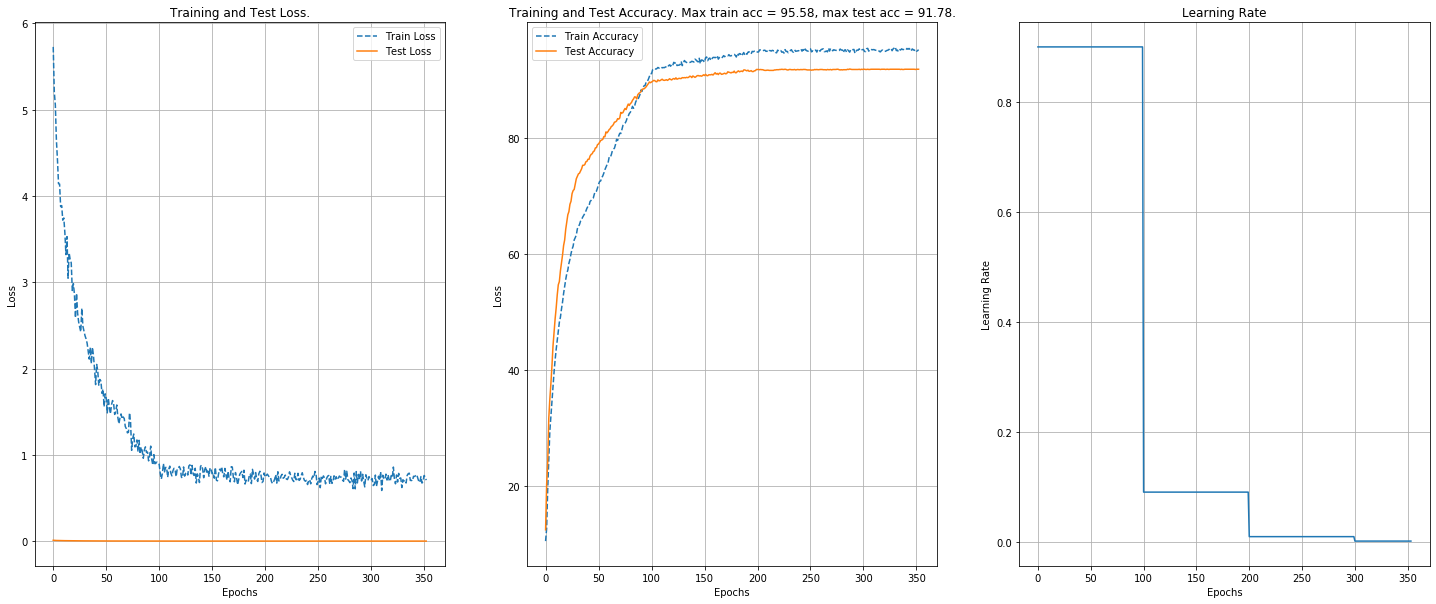

In [17]:
train_losses, train_acc = train_model.gettraindata()
test_losses, test_acc = train_model.gettestdata()
plotdata.PlotData.plottesttraingraph(train_losses=train_losses,train_acc=train_acc,test_losses=test_losses,
                                     test_acc=test_acc,lr_data=lr_data, plotonsamegraph=True,epochs=epochs,doProcessArray=False)

In [ ]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from models.inception_resnet_v1 import InceptionResnetV1
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, notebook
import csv
import glob
import dlib
import pandas as pd
import numpy as np
import dlib
from src.utils import renderFace
import matplotlib
%matplotlib inline

from src.imports import *

%config IPCompleter.greedy=True
%reload_ext autoreload

In [ ]:
print(torch.cuda.is_available())
saved_data, epoch, model_state_dict, optimizer_state_dict, train_losses, train_acc, test_losses, test_acc\
            , test_losses, lr_data, class_correct, class_total\
= utils.Utils.loadmodel(path="savedmodels/finalmodelwithdata.pt")

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms, test_transforms = preprochelper.PreprocHelper.getmnvetv2traintesttransforms(mean, std)


data_transforms = {
     'train': train_transforms,
     'val': test_transforms 
}

data_dir = '/media/abhijit/DATA/Development/MyRepos/lfw_funneled'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=512, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
# class_names

train_loader = dataloaders["train"]
test_loader = dataloaders["val"]

# data_iterator = iter(train_loader)
# plotdata.PlotData.showImagesfromdataset(data_iterator, classes=class_names, image_count=20, col=5)

# data_iterator = iter(test_loader)
# plotdata.PlotData.showImagesfromdataset(data_iterator, classes=class_names, image_count=20, col=5)

In [ ]:
from models.inception_resnet_v1 import InceptionResnetV1
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

list(model_ft.children())[-6:]

layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

model_ft = nn.Sequential(*list(model_ft.children())[:-5])

for param in model_ft.parameters():
    param.requires_grad = False
    
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x
    
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(layer_list[4].in_features, len(class_names))
# model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)

In [23]:
dataiterator = iter(test_loader)

classified, misclassified = train.TrainModel.getinferredimagesfromdataset(dataiterator=dataiterator, model=model_ft,
                                                                          classes=class_names, batch_size=512,
                                                                          number=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

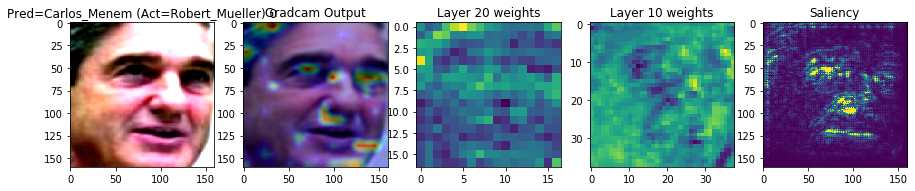

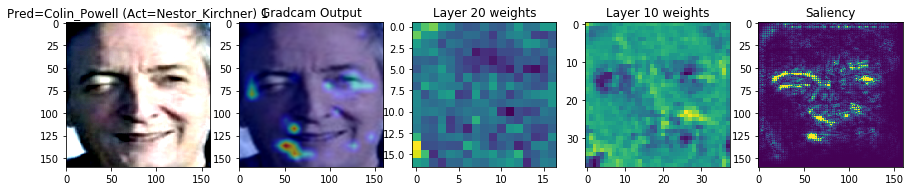

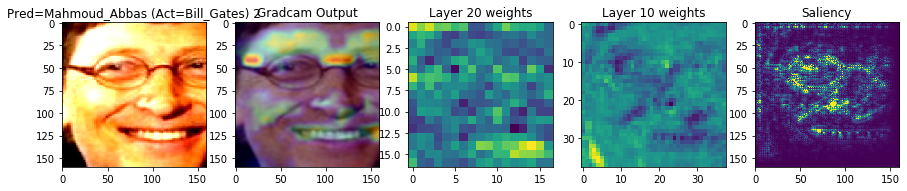

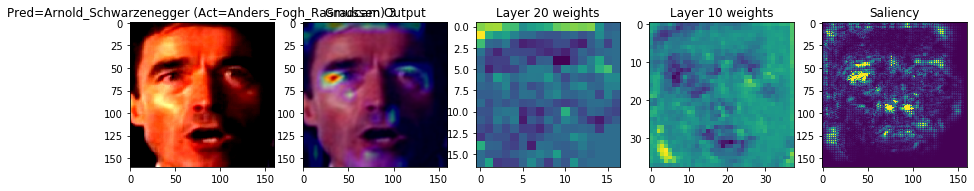

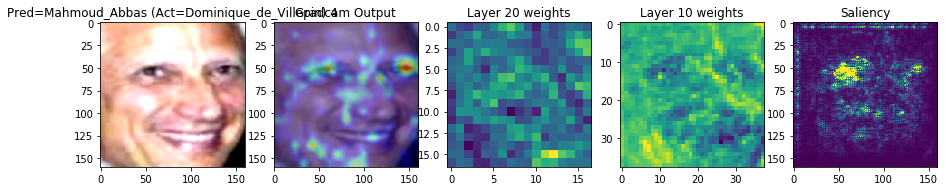

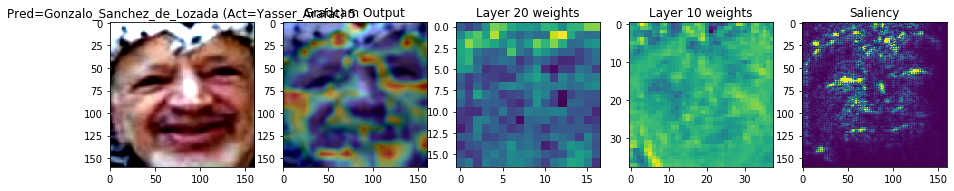

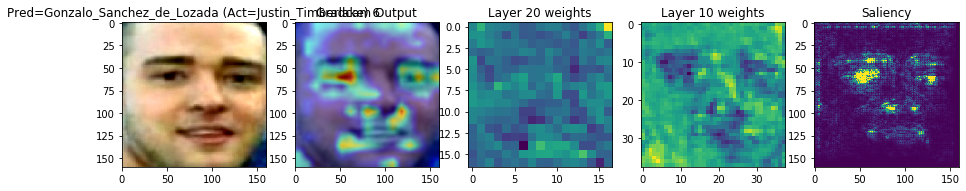

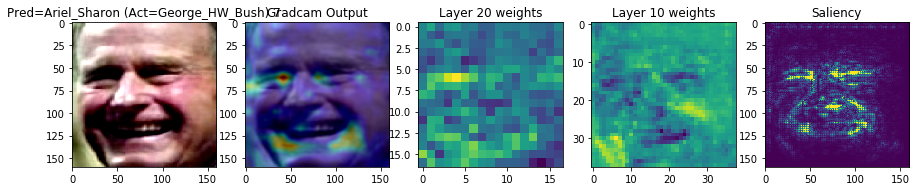

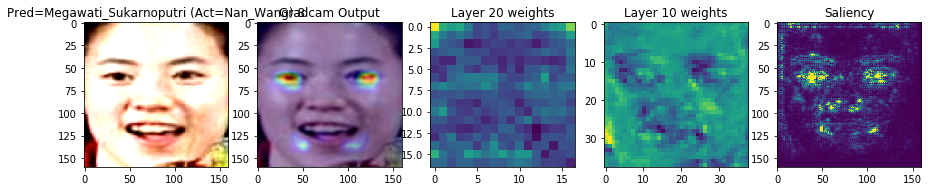

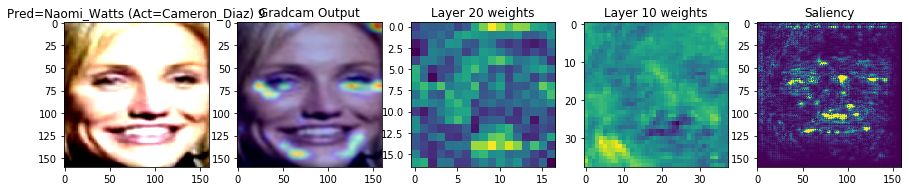

In [24]:
plotdata.PlotData.plotinferredimagesfromdataset(misclassified, model_ft, device, class_names,"misclassifed"
                                                ,size=(15,20),layerNo=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

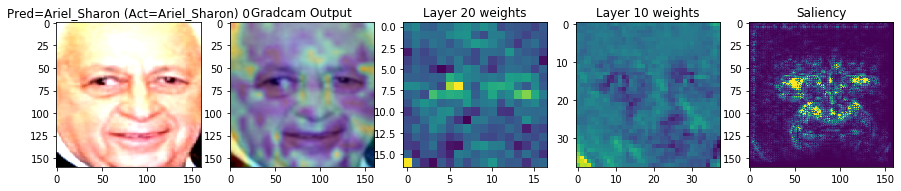

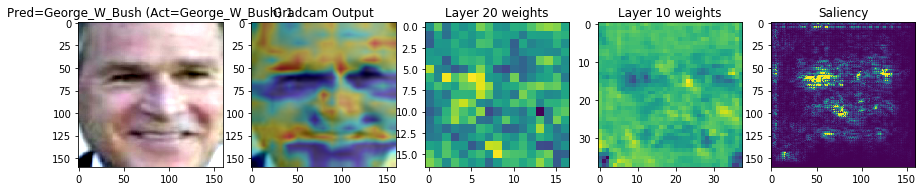

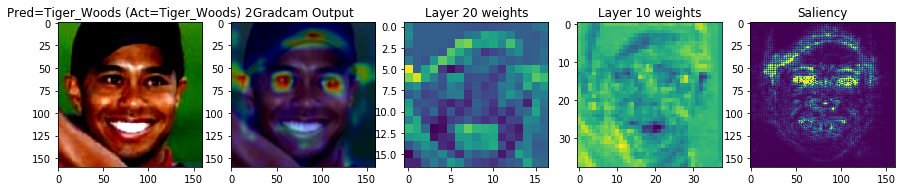

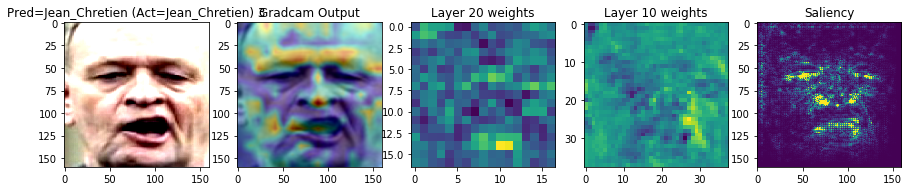

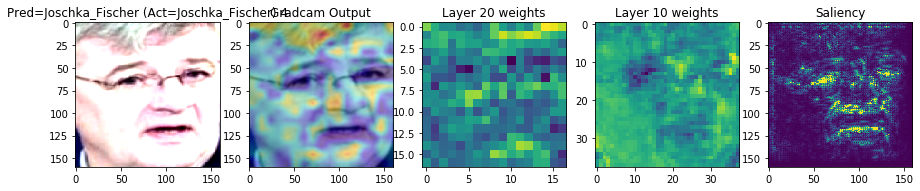

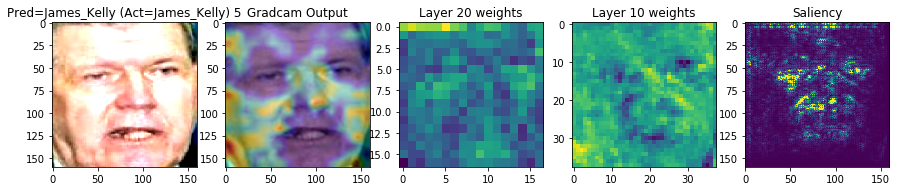

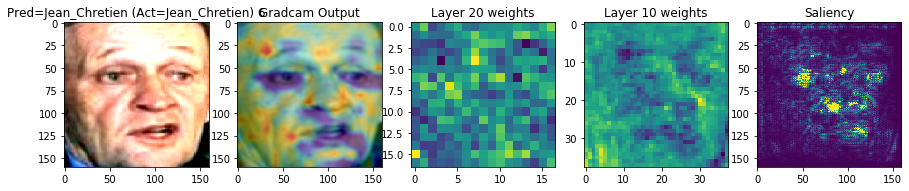

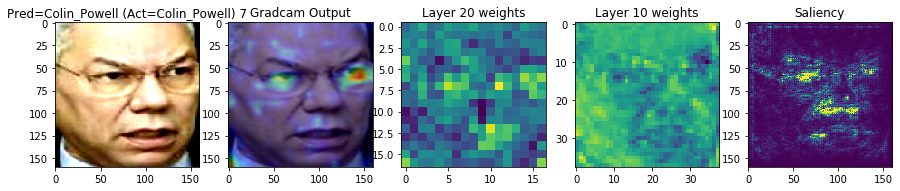

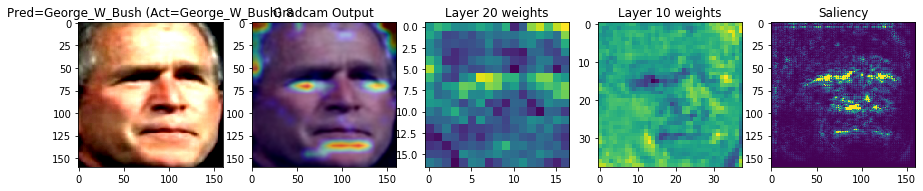

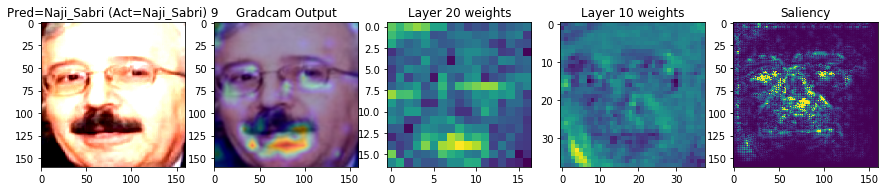

In [25]:
plotdata.PlotData.plotinferredimagesfromdataset(classified, model_ft, device, class_names,"correct"
                                                ,size=(15,20),layerNo=20)